Running simulation for L=8
Running simulation for L=16
Running simulation for L=32
Running simulation for L=64


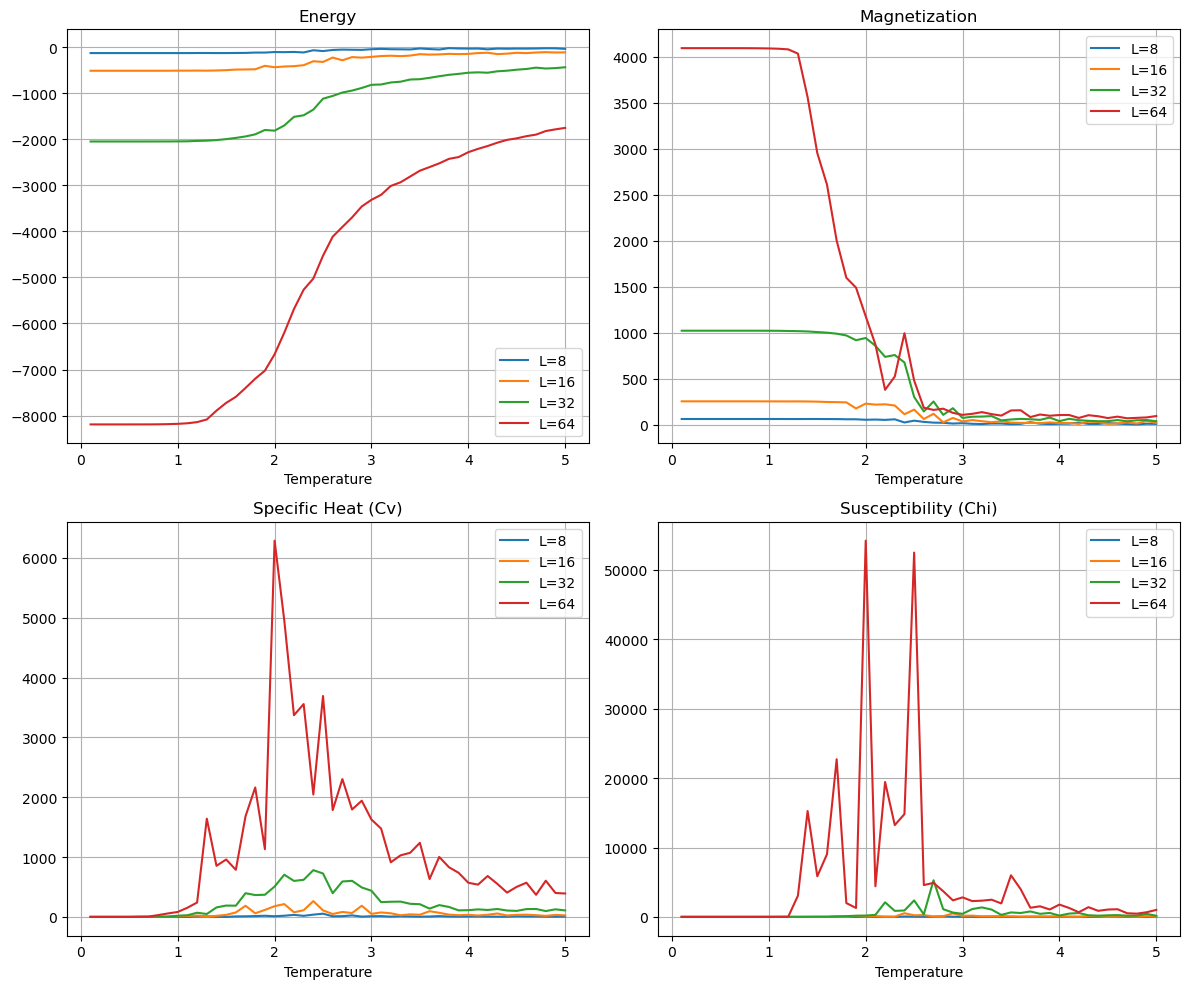

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit


@njit
def init_lattice(n):
    return 2 * np.random.randint(0, 2, size=(n, n)) - 1


@njit
def energy(latt):
    N = len(latt)
    e = 0
    for i in range(N):
        for j in range(N):
            S = latt[i, j]
            nb = latt[(i + 1) % N, j] + latt[i, (j + 1) % N]
            e += -S * nb
    return e


@njit
def magnetization(latt):
    return np.abs(np.sum(latt))


@njit
def metropolis_step(latt, beta, N):
    a = np.random.randint(0, N)
    b = np.random.randint(0, N)
    s = latt[a, b]
    nb = (
        latt[(a + 1) % N, b] + latt[(a - 1) % N, b] +
        latt[a, (b + 1) % N] + latt[a, (b - 1) % N]
    )
    dE = 2 * s * nb
    if dE < 0 or np.random.rand() < np.exp(-dE * beta):
        latt[a, b] = -s
    return energy(latt), magnetization(latt)


def simulate(latt, temps, n, n_eq=50000, n_samples=5):

    E, M, E2, M2 = [], [], [], []
    for T in temps:
        beta = 1.0 / T
        # Equilibration
        for _ in range(n_eq):
            metropolis_step(latt, beta, n)
        # Measurement
        e_acc, m_acc = [], []
        for _ in range(n ** 3):
            e, m = metropolis_step(latt, beta, n)
            e_acc.append(e)
            m_acc.append(m)
        e_arr, m_arr = np.array(e_acc), np.array(m_acc)
        E.append(np.mean(e_arr))
        M.append(np.mean(m_arr))
        E2.append(np.mean(e_arr ** 2))
        M2.append(np.mean(m_arr ** 2))
    return np.array(E), np.array(M), np.array(E2), np.array(M2)


def compute_observables(E, M, E2, M2, temps, n):
    Cv = (E2 - E ** 2) / (temps ** 2)
    Chi = (M2 - M ** 2) / temps
    return Cv, Chi



def run_all(sizes=[8, 16, 32, 64], temps=np.arange(4, 0, -0.1)):
    results = {}
    for n in sizes:
        print(f"Running simulation for L={n}")
        latt = init_lattice(n)
        E, M, E2, M2 = simulate(latt, temps, n)
        Cv, Chi = compute_observables(E, M, E2, M2, temps, n)
        results[n] = {"E": E, "M": M, "Cv": Cv, "Chi": Chi}
    return results


def plot_results(results, temps):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for n, res in results.items():
        axes[0, 0].plot(temps, res["E"], label=f"L={n}")
        axes[0, 1].plot(temps, res["M"], label=f"L={n}")
        axes[1, 0].plot(temps, res["Cv"], label=f"L={n}")
        axes[1, 1].plot(temps, res["Chi"], label=f"L={n}")

    axes[0, 0].set_title("Energy")
    axes[0, 1].set_title("Magnetization")
    axes[1, 0].set_title("Specific Heat (Cv)")
    axes[1, 1].set_title("Susceptibility (Chi)")

    for ax in axes.ravel():
        ax.set_xlabel("Temperature")
        ax.legend()
        ax.grid()

    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    temps = np.arange(5, 0, -0.1)
    sizes = [8, 16, 32, 64]
    results = run_all(sizes, temps)
    plot_results(results, temps)
